# IMPORTS
---

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from seaborn import heatmap
from tqdm import tqdm
import seaborn as sns

# Neural Network
---

## Component: Dense Layer

In [ ]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.randn(input_dim, output_dim) * 0.05
        self.biases = np.zeros((1, output_dim))

    def forward(self, X, testing=False):
        # Dense layer forward pass both in train, test
        self.input = X
        self.output = np.dot(X, self.weights) + self.biases
        return self.output

    def backward(self, d_output):
        d_input = np.dot(d_output, self.weights.T)
        d_weights = np.dot(self.input.T, d_output)
        d_biases = np.sum(d_output, axis=0, keepdims=True)
        
        self.weights -= self.learning_rate * d_weights
        self.biases -= self.learning_rate * d_biases
        
        return d_input

    def update_params(self, learning_rate):
        self.learning_rate = learning_rate

## Component: Batch Normalization

In [16]:
class BatchNormalization:
    def __init__(self, epsilon=1e-5, momentum=0.9):
        self.epsilon = epsilon
        self.momentum = momentum

    def forward(self, X, testing=False):
        if not testing:
            self.input = X
            self.mean = np.mean(X, axis=0)
            self.variance = np.var(X, axis=0)
            self.X_normalized = (X - self.mean) / np.sqrt(self.variance + self.epsilon)
        else:
            self.X_normalized = (X - self.mean) / np.sqrt(self.variance + self.epsilon)
        self.output = self.X_normalized
        return self.output

    def backward(self, d_output):
        N, D = d_output.shape
        X_mu = self.input - self.mean
        std_inv = 1. / np.sqrt(self.variance + self.epsilon)

        d_X_normalized = d_output * std_inv
        d_variance = np.sum(d_output * X_mu, axis=0) * -.5 * std_inv**3
        d_mean = np.sum(d_output * -std_inv, axis=0) + d_variance * np.mean(-2. * X_mu, axis=0)

        d_input = (d_X_normalized + (d_variance * 2 * X_mu / N) + (d_mean / N))
        return d_input

## Component: Activation

In [17]:
class ReLU:
    def forward(self, X, testing=False):
        self.input = X
        # Formula: output = 1 if X > 0, else 0
        self.output = np.maximum(0, X)
        return self.output

    def backward(self, d_output):
        d_input = d_output.copy()
        d_input[self.input <= 0] = 0
        return d_input

## Component: Regularization

In [18]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, X, testing=False):
        if not testing:
            self.mask = np.random.binomial(1, 1 - self.rate, size=X.shape) / (1 - self.rate)
            return X * self.mask
        else:
            return X

    def backward(self, d_output):
        return d_output * self.mask

## Component: Optimization

In [19]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1, self.beta2, self.epsilon = beta1, beta2, epsilon
        self.m, self.v = None, None
        self.t = 0

    def update(self, params, grads):
        if self.m is None:
            self.m = [np.zeros_like(param) for param in params]
            self.v = [np.zeros_like(param) for param in params]

        self.t += 1
        updated_params = []
        for i, (param, grad) in enumerate(zip(params, grads)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            param_update = param - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            updated_params.append(param_update)

        return updated_params

## Component: Regression

In [20]:
class Softmax:
    def forward(self, X, testing=False):
        # Softmax included in both training and testing
        exp_values = np.exp(X - np.max(X, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probabilities

    def backward(self, d_output):
        return d_output

## Network Architecture

In [ ]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X, testing=False):
        for layer in self.layers:
            X = layer.forward(X, testing=testing)
        return X

    def backward(self, d_output):
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output)

    def update_params(self, learning_rate):
        for layer in self.layers:
            if hasattr(layer, 'update_params'):
                layer.update_params(learning_rate)

    def print_metrics_table(self, performance_metrics):
        metrics_df = pd.DataFrame(
            performance_metrics, 
            columns=["Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy", "Val Macro F1"]
        )
        metrics_df.index = [f"Epoch {i+1}" for i in range(len(metrics_df))]
        print("\nTraining Metrics:")
        print("=" * 80)
        print(metrics_df)
        print("=" * 80)

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
        self.update_params(learning_rate)
        performance_metrics = []

        for epoch in range(epochs):
            total_batches = X_train.shape[0] // batch_size
            pbar = tqdm(total=total_batches, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

            train_loss, train_accuracy = 0, 0
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                output = self.forward(X_batch)
                loss = self.compute_loss(output, y_batch)
                train_loss += loss
                d_output = self.compute_loss_derivative(output, y_batch)

                self.backward(d_output)
                pbar.update(1)

            train_loss /= total_batches
            train_accuracy = self.compute_accuracy(self.forward(X_train), y_train)
            pbar.close()

            val_output = self.forward(X_val)
            val_loss = self.compute_loss(val_output, y_val)
            val_accuracy = self.compute_accuracy(val_output, y_val)

            val_predictions = np.argmax(val_output, axis=1)
            val_labels = np.argmax(y_val, axis=1)
            val_macro_f1 = f1_score(val_labels, val_predictions, average='macro')

            performance_metrics.append([train_loss, val_loss, train_accuracy, val_accuracy, val_macro_f1])

            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, "
                  f"Val Macro F1: {val_macro_f1:.4f}\n")

        self.print_metrics_table(performance_metrics)
        return performance_metrics  
    
    def compute_loss(self, output, y):
        return -np.mean(y * np.log(output + 1e-8))

    def compute_loss_derivative(self, output, y):
        return output - y

    def compute_accuracy(self, output, y):
        predictions = np.argmax(output, axis=1)
        labels = np.argmax(y, axis=1)
        return np.mean(predictions == labels)


## Model Save

In [22]:
def save_model(model, filepath):
    model_params = {}
    for idx, layer in enumerate(model.layers):
        if isinstance(layer, DenseLayer):
            model_params[f'weight_{idx}'] = layer.weights
            model_params[f'bias_{idx}'] = layer.biases
    with open(filepath, 'wb') as file:
        pickle.dump(model_params, file)

def load_model_weights(model, filepath):
    with open(filepath, 'rb') as file:
        model_params = pickle.load(file)
    for idx in range(len(model.layers)):
        if isinstance(model.layers[idx], DenseLayer):
            model.layers[idx].weights = model_params[f'weight_{idx}']
            model.layers[idx].biases = model_params[f'bias_{idx}']
    return model

# Plots

In [23]:
def train_and_evaluate(models, learning_rates, X_train, y_train, X_val, y_val, epochs, batch_size):
    history = {}
    best_model = None
    best_lr = None
    best_f1_score = 0.75
    
    for cnt, lr in enumerate(learning_rates):
        history[lr] = [] 
        
        for model_index, model in enumerate(models):
            print(f"\nModel - {model_index+1} | Training with learning rate: {lr}")
            model.update_params(lr)
            metrics_history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, lr)
            
            history[lr].append(metrics_history)
            val_macro_f1_avg = np.mean([epoch_metrics[-1] for epoch_metrics in metrics_history])

            save_model(model, f'model_{model_index + 1}_lr_{lr}.pkl')

            #print(f"Model - {model_index+1} | Validation Macro F1: {val_macro_f1_avg:.4f}")

            if val_macro_f1_avg > best_f1_score:
                best_f1_score = val_macro_f1_avg
                best_model = model
                best_lr = lr
    #print(f"\nBest Model | Validation Macro F1: {best_f1_score:.4f} best_lr: {best_lr}")                
    if best_model is not None:
        save_model(best_model, 'best_model.pkl')

    return best_model, best_lr, history


In [24]:
images_cls = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
def plot_confusion_matrix(data):
    plt.figure(figsize=(10, 7))
    sns.heatmap(data, annot=True, fmt='d', cmap='Blues', xticklabels=images_cls.values(), yticklabels=images_cls.values())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def test_and_evaluate(model, X_test, y_test):
    test_output = model.forward(X_test, testing=True)
    test_predictions = np.argmax(test_output, axis=1)
    test_labels = np.argmax(y_test, axis=1)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_macro_f1 = f1_score(test_labels, test_predictions, average='macro')
    test_confusion_matrix = confusion_matrix(test_labels, test_predictions)
    plot_confusion_matrix(test_confusion_matrix)
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Macro F1 Score: {test_macro_f1:.4f}")
    return test_accuracy, test_macro_f1

# Train - Test MODEL

In [25]:
train_dataframe = pd.read_csv('fashion-mnist_train.csv')

X = train_dataframe.drop(columns=['label']).values
y = pd.get_dummies(train_dataframe['label']).values 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.005, 0.001, 0.0005, 0.0001]

test_dataframe = pd.read_csv('fashion-mnist_test.csv') 
test_X = test_dataframe.drop(columns=['label']).values
test_y = pd.get_dummies(test_dataframe['label']).values

# Model 1: Simple model with fewer layers
layers_model_1 = [
    DenseLayer(784, 256),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    DenseLayer(256, 10),
    Softmax()
]

# Model 2: Moderate complexity
layers_model_2 = [
    DenseLayer(784, 256),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    DenseLayer(256, 128),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    DenseLayer(128, 10),
    Softmax()
]

# Model 3: More complex model with additional layers
layers_model_3 = [
    DenseLayer(784, 512),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    DenseLayer(512, 256),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    DenseLayer(256, 128),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    DenseLayer(128, 10),
    Softmax()
]

# Instantiate the three models with different layer architectures
models = [
    NeuralNetwork(layers_model_1),
    NeuralNetwork(layers_model_2),
    NeuralNetwork(layers_model_3)
]

best_model, best_lr, history = train_and_evaluate(models, learning_rates, X_train, y_train, X_val, y_val, epochs=15, batch_size=200)



Model - 1 | Training with learning rate: 0.005


Epoch 1/15: 100%|██████████| 240/240 [00:07<00:00, 33.12batch/s]


Train Loss: 0.0857, Val Loss: 0.0604, Train Accuracy: 0.7959, Val Accuracy: 0.7954, Val Macro F1: 0.7945



Epoch 2/15: 100%|██████████| 240/240 [00:06<00:00, 38.49batch/s]


Train Loss: 0.0513, Val Loss: 0.0492, Train Accuracy: 0.8346, Val Accuracy: 0.8269, Val Macro F1: 0.8282



Epoch 3/15: 100%|██████████| 240/240 [00:05<00:00, 44.98batch/s]


Train Loss: 0.0455, Val Loss: 0.0461, Train Accuracy: 0.8507, Val Accuracy: 0.8409, Val Macro F1: 0.8413



Epoch 4/15: 100%|██████████| 240/240 [00:05<00:00, 43.62batch/s]


Train Loss: 0.0426, Val Loss: 0.0432, Train Accuracy: 0.8628, Val Accuracy: 0.8482, Val Macro F1: 0.8486



Epoch 5/15: 100%|██████████| 240/240 [00:05<00:00, 45.69batch/s]


Train Loss: 0.0405, Val Loss: 0.0423, Train Accuracy: 0.8676, Val Accuracy: 0.8555, Val Macro F1: 0.8563



Epoch 6/15: 100%|██████████| 240/240 [00:05<00:00, 47.88batch/s]


Train Loss: 0.0389, Val Loss: 0.0425, Train Accuracy: 0.8690, Val Accuracy: 0.8541, Val Macro F1: 0.8545



Epoch 7/15: 100%|██████████| 240/240 [00:05<00:00, 47.32batch/s]


Train Loss: 0.0377, Val Loss: 0.0433, Train Accuracy: 0.8671, Val Accuracy: 0.8498, Val Macro F1: 0.8495



Epoch 8/15: 100%|██████████| 240/240 [00:05<00:00, 47.37batch/s]


Train Loss: 0.0366, Val Loss: 0.0422, Train Accuracy: 0.8737, Val Accuracy: 0.8532, Val Macro F1: 0.8538



Epoch 9/15: 100%|██████████| 240/240 [00:05<00:00, 45.32batch/s]


Train Loss: 0.0355, Val Loss: 0.0396, Train Accuracy: 0.8825, Val Accuracy: 0.8625, Val Macro F1: 0.8634



Epoch 10/15: 100%|██████████| 240/240 [00:05<00:00, 44.64batch/s]


Train Loss: 0.0346, Val Loss: 0.0404, Train Accuracy: 0.8836, Val Accuracy: 0.8638, Val Macro F1: 0.8645



Epoch 11/15: 100%|██████████| 240/240 [00:05<00:00, 46.41batch/s]


Train Loss: 0.0339, Val Loss: 0.0408, Train Accuracy: 0.8817, Val Accuracy: 0.8642, Val Macro F1: 0.8649



Epoch 12/15: 100%|██████████| 240/240 [00:05<00:00, 46.59batch/s]


Train Loss: 0.0329, Val Loss: 0.0410, Train Accuracy: 0.8880, Val Accuracy: 0.8618, Val Macro F1: 0.8624



Epoch 13/15: 100%|██████████| 240/240 [00:05<00:00, 46.14batch/s]


Train Loss: 0.0321, Val Loss: 0.0412, Train Accuracy: 0.8861, Val Accuracy: 0.8638, Val Macro F1: 0.8646



Epoch 14/15: 100%|██████████| 240/240 [00:05<00:00, 45.22batch/s]


Train Loss: 0.0318, Val Loss: 0.0399, Train Accuracy: 0.8904, Val Accuracy: 0.8644, Val Macro F1: 0.8651



Epoch 15/15: 100%|██████████| 240/240 [00:05<00:00, 45.84batch/s]


Train Loss: 0.0308, Val Loss: 0.0399, Train Accuracy: 0.8929, Val Accuracy: 0.8656, Val Macro F1: 0.8665


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.085676  0.060360        0.795937      0.795417      0.794503
Epoch 2     0.051332  0.049239        0.834562      0.826917      0.828214
Epoch 3     0.045537  0.046114        0.850708      0.840917      0.841269
Epoch 4     0.042639  0.043250        0.862833      0.848250      0.848564
Epoch 5     0.040478  0.042263        0.867625      0.855500      0.856279
Epoch 6     0.038922  0.042488        0.869000      0.854083      0.854451
Epoch 7     0.037695  0.043287        0.867104      0.849833      0.849532
Epoch 8     0.036559  0.042197        0.873687      0.853250      0.853792
Epoch 9     0.035485  0.039574        0.882542      0.862500      0.863431
Epoch 10    0.034597  0.040449        0.883563      0.863750      0.864452
Epoch 11    0.033903  0.040795        0.881708    

Epoch 1/15: 100%|██████████| 240/240 [00:07<00:00, 34.10batch/s]


Train Loss: 0.0710, Val Loss: 0.0568, Train Accuracy: 0.8022, Val Accuracy: 0.7958, Val Macro F1: 0.7982



Epoch 2/15: 100%|██████████| 240/240 [00:06<00:00, 35.92batch/s]


Train Loss: 0.0526, Val Loss: 0.0517, Train Accuracy: 0.8207, Val Accuracy: 0.8138, Val Macro F1: 0.8131



Epoch 3/15: 100%|██████████| 240/240 [00:06<00:00, 36.53batch/s]


Train Loss: 0.0481, Val Loss: 0.0471, Train Accuracy: 0.8380, Val Accuracy: 0.8280, Val Macro F1: 0.8288



Epoch 4/15: 100%|██████████| 240/240 [00:06<00:00, 35.67batch/s]


Train Loss: 0.0452, Val Loss: 0.0459, Train Accuracy: 0.8486, Val Accuracy: 0.8390, Val Macro F1: 0.8394



Epoch 5/15: 100%|██████████| 240/240 [00:06<00:00, 35.93batch/s]


Train Loss: 0.0433, Val Loss: 0.0443, Train Accuracy: 0.8517, Val Accuracy: 0.8422, Val Macro F1: 0.8435



Epoch 6/15: 100%|██████████| 240/240 [00:06<00:00, 36.96batch/s]


Train Loss: 0.0424, Val Loss: 0.0449, Train Accuracy: 0.8511, Val Accuracy: 0.8425, Val Macro F1: 0.8436



Epoch 7/15: 100%|██████████| 240/240 [00:06<00:00, 36.45batch/s]


Train Loss: 0.0406, Val Loss: 0.0432, Train Accuracy: 0.8591, Val Accuracy: 0.8461, Val Macro F1: 0.8459



Epoch 8/15: 100%|██████████| 240/240 [00:06<00:00, 37.29batch/s]


Train Loss: 0.0398, Val Loss: 0.0437, Train Accuracy: 0.8583, Val Accuracy: 0.8459, Val Macro F1: 0.8459



Epoch 9/15: 100%|██████████| 240/240 [00:06<00:00, 34.40batch/s]


Train Loss: 0.0389, Val Loss: 0.0411, Train Accuracy: 0.8668, Val Accuracy: 0.8568, Val Macro F1: 0.8580



Epoch 10/15: 100%|██████████| 240/240 [00:06<00:00, 34.64batch/s]


Train Loss: 0.0380, Val Loss: 0.0429, Train Accuracy: 0.8621, Val Accuracy: 0.8488, Val Macro F1: 0.8485



Epoch 11/15: 100%|██████████| 240/240 [00:06<00:00, 34.88batch/s]


Train Loss: 0.0373, Val Loss: 0.0417, Train Accuracy: 0.8668, Val Accuracy: 0.8555, Val Macro F1: 0.8567



Epoch 12/15: 100%|██████████| 240/240 [00:06<00:00, 36.50batch/s]


Train Loss: 0.0370, Val Loss: 0.0415, Train Accuracy: 0.8698, Val Accuracy: 0.8536, Val Macro F1: 0.8543



Epoch 13/15: 100%|██████████| 240/240 [00:06<00:00, 35.44batch/s]


Train Loss: 0.0361, Val Loss: 0.0418, Train Accuracy: 0.8688, Val Accuracy: 0.8538, Val Macro F1: 0.8547



Epoch 14/15: 100%|██████████| 240/240 [00:06<00:00, 34.67batch/s]


Train Loss: 0.0362, Val Loss: 0.0410, Train Accuracy: 0.8757, Val Accuracy: 0.8532, Val Macro F1: 0.8546



Epoch 15/15: 100%|██████████| 240/240 [00:07<00:00, 33.75batch/s]


Train Loss: 0.0351, Val Loss: 0.0404, Train Accuracy: 0.8787, Val Accuracy: 0.8617, Val Macro F1: 0.8624


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.070977  0.056777        0.802188      0.795833      0.798175
Epoch 2     0.052617  0.051666        0.820729      0.813833      0.813056
Epoch 3     0.048092  0.047116        0.838042      0.828000      0.828765
Epoch 4     0.045219  0.045914        0.848646      0.839000      0.839352
Epoch 5     0.043279  0.044319        0.851688      0.842167      0.843481
Epoch 6     0.042417  0.044877        0.851083      0.842500      0.843623
Epoch 7     0.040616  0.043234        0.859062      0.846083      0.845904
Epoch 8     0.039825  0.043690        0.858271      0.845917      0.845876
Epoch 9     0.038932  0.041096        0.866771      0.856750      0.857992
Epoch 10    0.038018  0.042943        0.862125      0.848750      0.848469
Epoch 11    0.037278  0.041706        0.866812    

Epoch 1/15: 100%|██████████| 240/240 [00:16<00:00, 14.46batch/s]


Train Loss: 0.0739, Val Loss: 0.0556, Train Accuracy: 0.8059, Val Accuracy: 0.8031, Val Macro F1: 0.8070



Epoch 2/15: 100%|██████████| 240/240 [00:14<00:00, 16.25batch/s]


Train Loss: 0.0532, Val Loss: 0.0513, Train Accuracy: 0.8270, Val Accuracy: 0.8229, Val Macro F1: 0.8241



Epoch 3/15: 100%|██████████| 240/240 [00:14<00:00, 16.61batch/s]


Train Loss: 0.0489, Val Loss: 0.0471, Train Accuracy: 0.8446, Val Accuracy: 0.8354, Val Macro F1: 0.8345



Epoch 4/15: 100%|██████████| 240/240 [00:13<00:00, 17.27batch/s]


Train Loss: 0.0452, Val Loss: 0.0456, Train Accuracy: 0.8482, Val Accuracy: 0.8412, Val Macro F1: 0.8416



Epoch 5/15: 100%|██████████| 240/240 [00:16<00:00, 14.85batch/s]


Train Loss: 0.0435, Val Loss: 0.0442, Train Accuracy: 0.8549, Val Accuracy: 0.8440, Val Macro F1: 0.8459



Epoch 6/15: 100%|██████████| 240/240 [00:15<00:00, 15.89batch/s]


Train Loss: 0.0415, Val Loss: 0.0432, Train Accuracy: 0.8615, Val Accuracy: 0.8473, Val Macro F1: 0.8491



Epoch 7/15: 100%|██████████| 240/240 [00:13<00:00, 17.43batch/s]


Train Loss: 0.0404, Val Loss: 0.0441, Train Accuracy: 0.8615, Val Accuracy: 0.8472, Val Macro F1: 0.8478



Epoch 8/15: 100%|██████████| 240/240 [00:13<00:00, 17.19batch/s]


Train Loss: 0.0394, Val Loss: 0.0425, Train Accuracy: 0.8670, Val Accuracy: 0.8511, Val Macro F1: 0.8522



Epoch 9/15: 100%|██████████| 240/240 [00:13<00:00, 17.30batch/s]


Train Loss: 0.0383, Val Loss: 0.0406, Train Accuracy: 0.8710, Val Accuracy: 0.8618, Val Macro F1: 0.8626



Epoch 10/15: 100%|██████████| 240/240 [00:16<00:00, 14.97batch/s]


Train Loss: 0.0376, Val Loss: 0.0405, Train Accuracy: 0.8758, Val Accuracy: 0.8607, Val Macro F1: 0.8608



Epoch 11/15: 100%|██████████| 240/240 [00:14<00:00, 17.09batch/s]


Train Loss: 0.0368, Val Loss: 0.0397, Train Accuracy: 0.8793, Val Accuracy: 0.8627, Val Macro F1: 0.8636



Epoch 12/15: 100%|██████████| 240/240 [00:13<00:00, 17.64batch/s]


Train Loss: 0.0360, Val Loss: 0.0402, Train Accuracy: 0.8789, Val Accuracy: 0.8585, Val Macro F1: 0.8587



Epoch 13/15: 100%|██████████| 240/240 [00:12<00:00, 19.39batch/s]


Train Loss: 0.0353, Val Loss: 0.0409, Train Accuracy: 0.8795, Val Accuracy: 0.8603, Val Macro F1: 0.8612



Epoch 14/15: 100%|██████████| 240/240 [00:12<00:00, 19.56batch/s]


Train Loss: 0.0343, Val Loss: 0.0395, Train Accuracy: 0.8823, Val Accuracy: 0.8637, Val Macro F1: 0.8644



Epoch 15/15: 100%|██████████| 240/240 [00:13<00:00, 17.51batch/s]


Train Loss: 0.0337, Val Loss: 0.0396, Train Accuracy: 0.8840, Val Accuracy: 0.8648, Val Macro F1: 0.8656


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.073898  0.055557        0.805896      0.803083      0.807001
Epoch 2     0.053245  0.051280        0.827000      0.822917      0.824096
Epoch 3     0.048861  0.047052        0.844583      0.835417      0.834507
Epoch 4     0.045183  0.045632        0.848208      0.841167      0.841583
Epoch 5     0.043480  0.044178        0.854896      0.844000      0.845910
Epoch 6     0.041482  0.043175        0.861479      0.847333      0.849134
Epoch 7     0.040367  0.044085        0.861521      0.847167      0.847831
Epoch 8     0.039373  0.042463        0.867042      0.851083      0.852154
Epoch 9     0.038293  0.040596        0.871042      0.861750      0.862612
Epoch 10    0.037556  0.040527        0.875771      0.860667      0.860846
Epoch 11    0.036816  0.039741        0.879313    

Epoch 1/15: 100%|██████████| 240/240 [00:05<00:00, 46.08batch/s]


Train Loss: 0.0273, Val Loss: 0.0366, Train Accuracy: 0.9070, Val Accuracy: 0.8772, Val Macro F1: 0.8780



Epoch 2/15: 100%|██████████| 240/240 [00:05<00:00, 46.27batch/s]


Train Loss: 0.0261, Val Loss: 0.0361, Train Accuracy: 0.9091, Val Accuracy: 0.8782, Val Macro F1: 0.8788



Epoch 3/15: 100%|██████████| 240/240 [00:05<00:00, 46.04batch/s]


Train Loss: 0.0255, Val Loss: 0.0357, Train Accuracy: 0.9095, Val Accuracy: 0.8767, Val Macro F1: 0.8775



Epoch 4/15: 100%|██████████| 240/240 [00:05<00:00, 45.13batch/s]


Train Loss: 0.0252, Val Loss: 0.0362, Train Accuracy: 0.9133, Val Accuracy: 0.8778, Val Macro F1: 0.8787



Epoch 5/15: 100%|██████████| 240/240 [00:04<00:00, 48.23batch/s]


Train Loss: 0.0249, Val Loss: 0.0360, Train Accuracy: 0.9114, Val Accuracy: 0.8780, Val Macro F1: 0.8786



Epoch 6/15: 100%|██████████| 240/240 [00:04<00:00, 52.83batch/s]


Train Loss: 0.0247, Val Loss: 0.0354, Train Accuracy: 0.9130, Val Accuracy: 0.8791, Val Macro F1: 0.8801



Epoch 7/15: 100%|██████████| 240/240 [00:04<00:00, 52.68batch/s]


Train Loss: 0.0241, Val Loss: 0.0354, Train Accuracy: 0.9139, Val Accuracy: 0.8802, Val Macro F1: 0.8811



Epoch 8/15: 100%|██████████| 240/240 [00:05<00:00, 44.50batch/s]


Train Loss: 0.0241, Val Loss: 0.0363, Train Accuracy: 0.9129, Val Accuracy: 0.8766, Val Macro F1: 0.8775



Epoch 9/15: 100%|██████████| 240/240 [00:05<00:00, 47.72batch/s]


Train Loss: 0.0239, Val Loss: 0.0361, Train Accuracy: 0.9174, Val Accuracy: 0.8771, Val Macro F1: 0.8781



Epoch 10/15: 100%|██████████| 240/240 [00:05<00:00, 45.05batch/s]


Train Loss: 0.0237, Val Loss: 0.0362, Train Accuracy: 0.9164, Val Accuracy: 0.8808, Val Macro F1: 0.8819



Epoch 11/15: 100%|██████████| 240/240 [00:05<00:00, 46.05batch/s]


Train Loss: 0.0235, Val Loss: 0.0359, Train Accuracy: 0.9175, Val Accuracy: 0.8812, Val Macro F1: 0.8820



Epoch 12/15: 100%|██████████| 240/240 [00:05<00:00, 43.98batch/s]


Train Loss: 0.0235, Val Loss: 0.0360, Train Accuracy: 0.9162, Val Accuracy: 0.8812, Val Macro F1: 0.8819



Epoch 13/15: 100%|██████████| 240/240 [00:05<00:00, 43.67batch/s]


Train Loss: 0.0234, Val Loss: 0.0364, Train Accuracy: 0.9186, Val Accuracy: 0.8796, Val Macro F1: 0.8802



Epoch 14/15: 100%|██████████| 240/240 [00:05<00:00, 45.88batch/s]


Train Loss: 0.0231, Val Loss: 0.0365, Train Accuracy: 0.9184, Val Accuracy: 0.8764, Val Macro F1: 0.8772



Epoch 15/15: 100%|██████████| 240/240 [00:05<00:00, 45.00batch/s]


Train Loss: 0.0230, Val Loss: 0.0370, Train Accuracy: 0.9199, Val Accuracy: 0.8798, Val Macro F1: 0.8804


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.027260  0.036583        0.907042      0.877250      0.877959
Epoch 2     0.026118  0.036069        0.909146      0.878250      0.878848
Epoch 3     0.025524  0.035659        0.909542      0.876667      0.877549
Epoch 4     0.025249  0.036221        0.913333      0.877833      0.878687
Epoch 5     0.024924  0.035967        0.911438      0.878000      0.878639
Epoch 6     0.024692  0.035419        0.912979      0.879083      0.880071
Epoch 7     0.024124  0.035440        0.913875      0.880167      0.881055
Epoch 8     0.024136  0.036310        0.912854      0.876583      0.877485
Epoch 9     0.023897  0.036144        0.917417      0.877083      0.878052
Epoch 10    0.023661  0.036178        0.916354      0.880833      0.881874
Epoch 11    0.023536  0.035897        0.917542    

Epoch 1/15: 100%|██████████| 240/240 [00:06<00:00, 35.41batch/s]


Train Loss: 0.0323, Val Loss: 0.0380, Train Accuracy: 0.8880, Val Accuracy: 0.8692, Val Macro F1: 0.8699



Epoch 2/15: 100%|██████████| 240/240 [00:05<00:00, 42.76batch/s]


Train Loss: 0.0311, Val Loss: 0.0381, Train Accuracy: 0.8894, Val Accuracy: 0.8669, Val Macro F1: 0.8678



Epoch 3/15: 100%|██████████| 240/240 [00:05<00:00, 43.30batch/s]


Train Loss: 0.0311, Val Loss: 0.0381, Train Accuracy: 0.8907, Val Accuracy: 0.8682, Val Macro F1: 0.8683



Epoch 4/15: 100%|██████████| 240/240 [00:05<00:00, 43.46batch/s]


Train Loss: 0.0307, Val Loss: 0.0379, Train Accuracy: 0.8903, Val Accuracy: 0.8678, Val Macro F1: 0.8688



Epoch 5/15: 100%|██████████| 240/240 [00:05<00:00, 41.24batch/s]


Train Loss: 0.0302, Val Loss: 0.0373, Train Accuracy: 0.8922, Val Accuracy: 0.8710, Val Macro F1: 0.8718



Epoch 6/15: 100%|██████████| 240/240 [00:05<00:00, 43.18batch/s]


Train Loss: 0.0303, Val Loss: 0.0375, Train Accuracy: 0.8919, Val Accuracy: 0.8700, Val Macro F1: 0.8704



Epoch 7/15: 100%|██████████| 240/240 [00:05<00:00, 43.16batch/s]


Train Loss: 0.0301, Val Loss: 0.0380, Train Accuracy: 0.8955, Val Accuracy: 0.8682, Val Macro F1: 0.8689



Epoch 8/15: 100%|██████████| 240/240 [00:05<00:00, 43.30batch/s]


Train Loss: 0.0299, Val Loss: 0.0378, Train Accuracy: 0.8944, Val Accuracy: 0.8707, Val Macro F1: 0.8713



Epoch 9/15: 100%|██████████| 240/240 [00:05<00:00, 42.37batch/s]


Train Loss: 0.0296, Val Loss: 0.0375, Train Accuracy: 0.8916, Val Accuracy: 0.8695, Val Macro F1: 0.8702



Epoch 10/15: 100%|██████████| 240/240 [00:05<00:00, 42.92batch/s]


Train Loss: 0.0294, Val Loss: 0.0375, Train Accuracy: 0.8950, Val Accuracy: 0.8716, Val Macro F1: 0.8722



Epoch 11/15: 100%|██████████| 240/240 [00:05<00:00, 42.84batch/s]


Train Loss: 0.0294, Val Loss: 0.0378, Train Accuracy: 0.8932, Val Accuracy: 0.8671, Val Macro F1: 0.8678



Epoch 12/15: 100%|██████████| 240/240 [00:05<00:00, 43.39batch/s]


Train Loss: 0.0288, Val Loss: 0.0380, Train Accuracy: 0.8964, Val Accuracy: 0.8712, Val Macro F1: 0.8719



Epoch 13/15: 100%|██████████| 240/240 [00:05<00:00, 42.69batch/s]


Train Loss: 0.0291, Val Loss: 0.0382, Train Accuracy: 0.8964, Val Accuracy: 0.8677, Val Macro F1: 0.8678



Epoch 14/15: 100%|██████████| 240/240 [00:05<00:00, 42.33batch/s]


Train Loss: 0.0288, Val Loss: 0.0386, Train Accuracy: 0.8979, Val Accuracy: 0.8708, Val Macro F1: 0.8711



Epoch 15/15: 100%|██████████| 240/240 [00:05<00:00, 43.80batch/s]


Train Loss: 0.0290, Val Loss: 0.0370, Train Accuracy: 0.8981, Val Accuracy: 0.8739, Val Macro F1: 0.8747


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.032319  0.037959        0.887979      0.869250      0.869949
Epoch 2     0.031067  0.038126        0.889417      0.866917      0.867828
Epoch 3     0.031067  0.038144        0.890687      0.868167      0.868264
Epoch 4     0.030704  0.037950        0.890292      0.867833      0.868842
Epoch 5     0.030193  0.037346        0.892208      0.871000      0.871825
Epoch 6     0.030328  0.037460        0.891875      0.870000      0.870441
Epoch 7     0.030109  0.038028        0.895479      0.868167      0.868922
Epoch 8     0.029885  0.037844        0.894354      0.870667      0.871348
Epoch 9     0.029600  0.037460        0.891646      0.869500      0.870168
Epoch 10    0.029445  0.037503        0.894958      0.871583      0.872213
Epoch 11    0.029393  0.037840        0.893250    

Epoch 1/15: 100%|██████████| 240/240 [00:11<00:00, 20.25batch/s]


Train Loss: 0.0312, Val Loss: 0.0369, Train Accuracy: 0.8952, Val Accuracy: 0.8721, Val Macro F1: 0.8730



Epoch 2/15: 100%|██████████| 240/240 [00:11<00:00, 20.12batch/s]


Train Loss: 0.0296, Val Loss: 0.0373, Train Accuracy: 0.8981, Val Accuracy: 0.8722, Val Macro F1: 0.8728



Epoch 3/15: 100%|██████████| 240/240 [00:12<00:00, 19.97batch/s]


Train Loss: 0.0296, Val Loss: 0.0365, Train Accuracy: 0.8979, Val Accuracy: 0.8745, Val Macro F1: 0.8754



Epoch 4/15: 100%|██████████| 240/240 [00:12<00:00, 19.77batch/s]


Train Loss: 0.0289, Val Loss: 0.0364, Train Accuracy: 0.9003, Val Accuracy: 0.8747, Val Macro F1: 0.8754



Epoch 5/15: 100%|██████████| 240/240 [00:11<00:00, 20.14batch/s]


Train Loss: 0.0289, Val Loss: 0.0360, Train Accuracy: 0.8995, Val Accuracy: 0.8755, Val Macro F1: 0.8760



Epoch 6/15: 100%|██████████| 240/240 [00:12<00:00, 19.93batch/s]


Train Loss: 0.0284, Val Loss: 0.0370, Train Accuracy: 0.9004, Val Accuracy: 0.8725, Val Macro F1: 0.8730



Epoch 7/15: 100%|██████████| 240/240 [00:11<00:00, 20.06batch/s]


Train Loss: 0.0283, Val Loss: 0.0368, Train Accuracy: 0.9014, Val Accuracy: 0.8757, Val Macro F1: 0.8759



Epoch 8/15: 100%|██████████| 240/240 [00:12<00:00, 19.28batch/s]


Train Loss: 0.0281, Val Loss: 0.0364, Train Accuracy: 0.9036, Val Accuracy: 0.8772, Val Macro F1: 0.8777



Epoch 9/15: 100%|██████████| 240/240 [00:13<00:00, 17.82batch/s]


Train Loss: 0.0281, Val Loss: 0.0359, Train Accuracy: 0.9032, Val Accuracy: 0.8768, Val Macro F1: 0.8776



Epoch 10/15: 100%|██████████| 240/240 [00:13<00:00, 18.08batch/s]


Train Loss: 0.0277, Val Loss: 0.0365, Train Accuracy: 0.9045, Val Accuracy: 0.8752, Val Macro F1: 0.8758



Epoch 11/15: 100%|██████████| 240/240 [00:12<00:00, 19.52batch/s]


Train Loss: 0.0276, Val Loss: 0.0365, Train Accuracy: 0.9026, Val Accuracy: 0.8761, Val Macro F1: 0.8764



Epoch 12/15: 100%|██████████| 240/240 [00:12<00:00, 19.95batch/s]


Train Loss: 0.0272, Val Loss: 0.0365, Train Accuracy: 0.9034, Val Accuracy: 0.8768, Val Macro F1: 0.8774



Epoch 13/15: 100%|██████████| 240/240 [00:12<00:00, 19.87batch/s]


Train Loss: 0.0269, Val Loss: 0.0352, Train Accuracy: 0.9039, Val Accuracy: 0.8785, Val Macro F1: 0.8792



Epoch 14/15: 100%|██████████| 240/240 [00:12<00:00, 19.88batch/s]


Train Loss: 0.0266, Val Loss: 0.0361, Train Accuracy: 0.9060, Val Accuracy: 0.8778, Val Macro F1: 0.8786



Epoch 15/15: 100%|██████████| 240/240 [00:12<00:00, 19.69batch/s]


Train Loss: 0.0268, Val Loss: 0.0367, Train Accuracy: 0.9062, Val Accuracy: 0.8759, Val Macro F1: 0.8762


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.031200  0.036920        0.895250      0.872083      0.872951
Epoch 2     0.029614  0.037344        0.898146      0.872250      0.872827
Epoch 3     0.029627  0.036494        0.897917      0.874500      0.875378
Epoch 4     0.028857  0.036403        0.900271      0.874667      0.875352
Epoch 5     0.028898  0.035966        0.899542      0.875500      0.875955
Epoch 6     0.028385  0.036978        0.900375      0.872500      0.873040
Epoch 7     0.028306  0.036753        0.901354      0.875667      0.875922
Epoch 8     0.028120  0.036438        0.903625      0.877250      0.877742
Epoch 9     0.028076  0.035922        0.903250      0.876833      0.877573
Epoch 10    0.027653  0.036452        0.904458      0.875167      0.875821
Epoch 11    0.027583  0.036475        0.902625    

Epoch 1/15: 100%|██████████| 240/240 [00:04<00:00, 54.05batch/s]


Train Loss: 0.0223, Val Loss: 0.0359, Train Accuracy: 0.9210, Val Accuracy: 0.8806, Val Macro F1: 0.8816



Epoch 2/15: 100%|██████████| 240/240 [00:04<00:00, 54.29batch/s]


Train Loss: 0.0220, Val Loss: 0.0360, Train Accuracy: 0.9202, Val Accuracy: 0.8802, Val Macro F1: 0.8811



Epoch 3/15: 100%|██████████| 240/240 [00:04<00:00, 54.70batch/s]


Train Loss: 0.0222, Val Loss: 0.0361, Train Accuracy: 0.9214, Val Accuracy: 0.8779, Val Macro F1: 0.8788



Epoch 4/15: 100%|██████████| 240/240 [00:04<00:00, 53.24batch/s]


Train Loss: 0.0217, Val Loss: 0.0360, Train Accuracy: 0.9219, Val Accuracy: 0.8816, Val Macro F1: 0.8826



Epoch 5/15: 100%|██████████| 240/240 [00:04<00:00, 54.20batch/s]


Train Loss: 0.0217, Val Loss: 0.0360, Train Accuracy: 0.9226, Val Accuracy: 0.8803, Val Macro F1: 0.8812



Epoch 6/15: 100%|██████████| 240/240 [00:04<00:00, 54.74batch/s]


Train Loss: 0.0218, Val Loss: 0.0361, Train Accuracy: 0.9214, Val Accuracy: 0.8859, Val Macro F1: 0.8867



Epoch 7/15: 100%|██████████| 240/240 [00:04<00:00, 55.16batch/s]


Train Loss: 0.0214, Val Loss: 0.0364, Train Accuracy: 0.9223, Val Accuracy: 0.8772, Val Macro F1: 0.8780



Epoch 8/15: 100%|██████████| 240/240 [00:04<00:00, 54.87batch/s]


Train Loss: 0.0217, Val Loss: 0.0360, Train Accuracy: 0.9234, Val Accuracy: 0.8821, Val Macro F1: 0.8830



Epoch 9/15: 100%|██████████| 240/240 [00:04<00:00, 53.94batch/s]


Train Loss: 0.0218, Val Loss: 0.0358, Train Accuracy: 0.9247, Val Accuracy: 0.8812, Val Macro F1: 0.8820



Epoch 10/15: 100%|██████████| 240/240 [00:04<00:00, 54.17batch/s]


Train Loss: 0.0216, Val Loss: 0.0367, Train Accuracy: 0.9230, Val Accuracy: 0.8792, Val Macro F1: 0.8802



Epoch 11/15: 100%|██████████| 240/240 [00:04<00:00, 54.33batch/s]


Train Loss: 0.0212, Val Loss: 0.0357, Train Accuracy: 0.9236, Val Accuracy: 0.8811, Val Macro F1: 0.8821



Epoch 12/15: 100%|██████████| 240/240 [00:04<00:00, 52.46batch/s]


Train Loss: 0.0211, Val Loss: 0.0360, Train Accuracy: 0.9248, Val Accuracy: 0.8822, Val Macro F1: 0.8828



Epoch 13/15: 100%|██████████| 240/240 [00:04<00:00, 53.30batch/s]


Train Loss: 0.0214, Val Loss: 0.0361, Train Accuracy: 0.9245, Val Accuracy: 0.8788, Val Macro F1: 0.8794



Epoch 14/15: 100%|██████████| 240/240 [00:04<00:00, 53.74batch/s]


Train Loss: 0.0211, Val Loss: 0.0363, Train Accuracy: 0.9226, Val Accuracy: 0.8810, Val Macro F1: 0.8818



Epoch 15/15: 100%|██████████| 240/240 [00:04<00:00, 51.95batch/s]


Train Loss: 0.0210, Val Loss: 0.0366, Train Accuracy: 0.9245, Val Accuracy: 0.8806, Val Macro F1: 0.8812


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.022334  0.035876        0.920979      0.880583      0.881552
Epoch 2     0.022024  0.035972        0.920188      0.880167      0.881099
Epoch 3     0.022248  0.036120        0.921375      0.877917      0.878821
Epoch 4     0.021710  0.035973        0.921875      0.881583      0.882638
Epoch 5     0.021660  0.035960        0.922583      0.880333      0.881178
Epoch 6     0.021792  0.036085        0.921417      0.885917      0.886749
Epoch 7     0.021400  0.036353        0.922271      0.877250      0.877954
Epoch 8     0.021693  0.035986        0.923354      0.882083      0.883000
Epoch 9     0.021811  0.035755        0.924687      0.881167      0.882037
Epoch 10    0.021552  0.036739        0.922958      0.879250      0.880162
Epoch 11    0.021207  0.035696        0.923583    

Epoch 1/15: 100%|██████████| 240/240 [00:05<00:00, 42.76batch/s]


Train Loss: 0.0284, Val Loss: 0.0376, Train Accuracy: 0.8999, Val Accuracy: 0.8711, Val Macro F1: 0.8716



Epoch 2/15: 100%|██████████| 240/240 [00:05<00:00, 42.39batch/s]


Train Loss: 0.0278, Val Loss: 0.0375, Train Accuracy: 0.9007, Val Accuracy: 0.8726, Val Macro F1: 0.8733



Epoch 3/15: 100%|██████████| 240/240 [00:05<00:00, 42.35batch/s]


Train Loss: 0.0279, Val Loss: 0.0376, Train Accuracy: 0.8997, Val Accuracy: 0.8700, Val Macro F1: 0.8707



Epoch 4/15: 100%|██████████| 240/240 [00:05<00:00, 42.58batch/s]


Train Loss: 0.0278, Val Loss: 0.0372, Train Accuracy: 0.9001, Val Accuracy: 0.8732, Val Macro F1: 0.8739



Epoch 5/15: 100%|██████████| 240/240 [00:05<00:00, 42.19batch/s]


Train Loss: 0.0278, Val Loss: 0.0386, Train Accuracy: 0.8988, Val Accuracy: 0.8705, Val Macro F1: 0.8712



Epoch 6/15: 100%|██████████| 240/240 [00:05<00:00, 42.47batch/s]


Train Loss: 0.0277, Val Loss: 0.0364, Train Accuracy: 0.8999, Val Accuracy: 0.8739, Val Macro F1: 0.8746



Epoch 7/15: 100%|██████████| 240/240 [00:05<00:00, 40.69batch/s]


Train Loss: 0.0277, Val Loss: 0.0364, Train Accuracy: 0.9012, Val Accuracy: 0.8748, Val Macro F1: 0.8756



Epoch 8/15: 100%|██████████| 240/240 [00:05<00:00, 41.01batch/s]


Train Loss: 0.0277, Val Loss: 0.0371, Train Accuracy: 0.9011, Val Accuracy: 0.8737, Val Macro F1: 0.8743



Epoch 9/15: 100%|██████████| 240/240 [00:05<00:00, 40.03batch/s]


Train Loss: 0.0277, Val Loss: 0.0367, Train Accuracy: 0.9005, Val Accuracy: 0.8748, Val Macro F1: 0.8754



Epoch 10/15: 100%|██████████| 240/240 [00:06<00:00, 35.78batch/s]


Train Loss: 0.0272, Val Loss: 0.0377, Train Accuracy: 0.9002, Val Accuracy: 0.8731, Val Macro F1: 0.8741



Epoch 11/15: 100%|██████████| 240/240 [00:06<00:00, 36.61batch/s]


Train Loss: 0.0271, Val Loss: 0.0376, Train Accuracy: 0.9018, Val Accuracy: 0.8742, Val Macro F1: 0.8748



Epoch 12/15: 100%|██████████| 240/240 [00:06<00:00, 36.72batch/s]


Train Loss: 0.0273, Val Loss: 0.0370, Train Accuracy: 0.9019, Val Accuracy: 0.8745, Val Macro F1: 0.8753



Epoch 13/15: 100%|██████████| 240/240 [00:06<00:00, 36.39batch/s]


Train Loss: 0.0274, Val Loss: 0.0381, Train Accuracy: 0.9022, Val Accuracy: 0.8723, Val Macro F1: 0.8730



Epoch 14/15: 100%|██████████| 240/240 [00:06<00:00, 36.64batch/s]


Train Loss: 0.0273, Val Loss: 0.0374, Train Accuracy: 0.9031, Val Accuracy: 0.8704, Val Macro F1: 0.8712



Epoch 15/15: 100%|██████████| 240/240 [00:06<00:00, 36.93batch/s]


Train Loss: 0.0274, Val Loss: 0.0374, Train Accuracy: 0.9020, Val Accuracy: 0.8712, Val Macro F1: 0.8720


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.028426  0.037626        0.899854      0.871083      0.871582
Epoch 2     0.027788  0.037486        0.900708      0.872583      0.873255
Epoch 3     0.027870  0.037566        0.899729      0.870000      0.870666
Epoch 4     0.027833  0.037152        0.900146      0.873167      0.873908
Epoch 5     0.027788  0.038603        0.898750      0.870500      0.871206
Epoch 6     0.027705  0.036381        0.899896      0.873917      0.874593
Epoch 7     0.027665  0.036443        0.901167      0.874833      0.875598
Epoch 8     0.027720  0.037069        0.901125      0.873667      0.874267
Epoch 9     0.027660  0.036674        0.900458      0.874833      0.875376
Epoch 10    0.027209  0.037696        0.900208      0.873083      0.874105
Epoch 11    0.027061  0.037576        0.901750    

Epoch 1/15: 100%|██████████| 240/240 [00:13<00:00, 17.82batch/s]


Train Loss: 0.0264, Val Loss: 0.0361, Train Accuracy: 0.9080, Val Accuracy: 0.8772, Val Macro F1: 0.8780



Epoch 2/15: 100%|██████████| 240/240 [00:13<00:00, 18.09batch/s]


Train Loss: 0.0261, Val Loss: 0.0367, Train Accuracy: 0.9079, Val Accuracy: 0.8768, Val Macro F1: 0.8773



Epoch 3/15: 100%|██████████| 240/240 [00:12<00:00, 19.83batch/s]


Train Loss: 0.0260, Val Loss: 0.0365, Train Accuracy: 0.9082, Val Accuracy: 0.8754, Val Macro F1: 0.8761



Epoch 4/15: 100%|██████████| 240/240 [00:12<00:00, 19.89batch/s]


Train Loss: 0.0259, Val Loss: 0.0366, Train Accuracy: 0.9086, Val Accuracy: 0.8761, Val Macro F1: 0.8765



Epoch 5/15: 100%|██████████| 240/240 [00:11<00:00, 20.12batch/s]


Train Loss: 0.0259, Val Loss: 0.0367, Train Accuracy: 0.9085, Val Accuracy: 0.8765, Val Macro F1: 0.8772



Epoch 6/15: 100%|██████████| 240/240 [00:13<00:00, 18.34batch/s]


Train Loss: 0.0255, Val Loss: 0.0357, Train Accuracy: 0.9095, Val Accuracy: 0.8771, Val Macro F1: 0.8778



Epoch 7/15: 100%|██████████| 240/240 [00:14<00:00, 16.84batch/s]


Train Loss: 0.0253, Val Loss: 0.0360, Train Accuracy: 0.9103, Val Accuracy: 0.8796, Val Macro F1: 0.8801



Epoch 8/15: 100%|██████████| 240/240 [00:12<00:00, 19.57batch/s]


Train Loss: 0.0253, Val Loss: 0.0362, Train Accuracy: 0.9101, Val Accuracy: 0.8806, Val Macro F1: 0.8810



Epoch 9/15: 100%|██████████| 240/240 [00:12<00:00, 19.16batch/s]


Train Loss: 0.0254, Val Loss: 0.0353, Train Accuracy: 0.9099, Val Accuracy: 0.8780, Val Macro F1: 0.8785



Epoch 10/15: 100%|██████████| 240/240 [00:12<00:00, 18.78batch/s]


Train Loss: 0.0255, Val Loss: 0.0356, Train Accuracy: 0.9116, Val Accuracy: 0.8774, Val Macro F1: 0.8779



Epoch 11/15: 100%|██████████| 240/240 [00:12<00:00, 18.92batch/s]


Train Loss: 0.0252, Val Loss: 0.0364, Train Accuracy: 0.9114, Val Accuracy: 0.8795, Val Macro F1: 0.8800



Epoch 12/15: 100%|██████████| 240/240 [00:11<00:00, 21.02batch/s]


Train Loss: 0.0254, Val Loss: 0.0358, Train Accuracy: 0.9113, Val Accuracy: 0.8800, Val Macro F1: 0.8805



Epoch 13/15: 100%|██████████| 240/240 [00:10<00:00, 22.25batch/s]


Train Loss: 0.0252, Val Loss: 0.0374, Train Accuracy: 0.9132, Val Accuracy: 0.8771, Val Macro F1: 0.8777



Epoch 14/15: 100%|██████████| 240/240 [00:12<00:00, 19.84batch/s]


Train Loss: 0.0249, Val Loss: 0.0358, Train Accuracy: 0.9114, Val Accuracy: 0.8792, Val Macro F1: 0.8801



Epoch 15/15: 100%|██████████| 240/240 [00:12<00:00, 18.98batch/s]


Train Loss: 0.0249, Val Loss: 0.0368, Train Accuracy: 0.9133, Val Accuracy: 0.8802, Val Macro F1: 0.8807


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.026378  0.036054        0.907979      0.877167      0.877979
Epoch 2     0.026086  0.036674        0.907875      0.876833      0.877268
Epoch 3     0.025958  0.036520        0.908208      0.875417      0.876137
Epoch 4     0.025921  0.036570        0.908563      0.876083      0.876512
Epoch 5     0.025940  0.036690        0.908542      0.876500      0.877234
Epoch 6     0.025475  0.035699        0.909479      0.877083      0.877770
Epoch 7     0.025327  0.036030        0.910250      0.879583      0.880088
Epoch 8     0.025276  0.036214        0.910104      0.880583      0.881012
Epoch 9     0.025378  0.035297        0.909875      0.878000      0.878522
Epoch 10    0.025495  0.035553        0.911583      0.877417      0.877873
Epoch 11    0.025170  0.036391        0.911417    

Epoch 1/15: 100%|██████████| 240/240 [00:05<00:00, 43.36batch/s]


Train Loss: 0.0205, Val Loss: 0.0365, Train Accuracy: 0.9268, Val Accuracy: 0.8786, Val Macro F1: 0.8798



Epoch 2/15: 100%|██████████| 240/240 [00:04<00:00, 48.54batch/s]


Train Loss: 0.0204, Val Loss: 0.0357, Train Accuracy: 0.9245, Val Accuracy: 0.8828, Val Macro F1: 0.8837



Epoch 3/15: 100%|██████████| 240/240 [00:05<00:00, 47.46batch/s]


Train Loss: 0.0203, Val Loss: 0.0363, Train Accuracy: 0.9257, Val Accuracy: 0.8812, Val Macro F1: 0.8820



Epoch 4/15: 100%|██████████| 240/240 [00:04<00:00, 56.10batch/s]


Train Loss: 0.0205, Val Loss: 0.0362, Train Accuracy: 0.9266, Val Accuracy: 0.8813, Val Macro F1: 0.8823



Epoch 5/15: 100%|██████████| 240/240 [00:04<00:00, 55.67batch/s]


Train Loss: 0.0203, Val Loss: 0.0360, Train Accuracy: 0.9258, Val Accuracy: 0.8804, Val Macro F1: 0.8815



Epoch 6/15: 100%|██████████| 240/240 [00:05<00:00, 47.93batch/s]


Train Loss: 0.0205, Val Loss: 0.0356, Train Accuracy: 0.9262, Val Accuracy: 0.8838, Val Macro F1: 0.8846



Epoch 7/15: 100%|██████████| 240/240 [00:03<00:00, 62.68batch/s]


Train Loss: 0.0204, Val Loss: 0.0363, Train Accuracy: 0.9279, Val Accuracy: 0.8807, Val Macro F1: 0.8816



Epoch 8/15: 100%|██████████| 240/240 [00:03<00:00, 61.13batch/s]


Train Loss: 0.0203, Val Loss: 0.0361, Train Accuracy: 0.9270, Val Accuracy: 0.8811, Val Macro F1: 0.8819



Epoch 9/15: 100%|██████████| 240/240 [00:03<00:00, 62.10batch/s]


Train Loss: 0.0203, Val Loss: 0.0355, Train Accuracy: 0.9258, Val Accuracy: 0.8838, Val Macro F1: 0.8847



Epoch 10/15: 100%|██████████| 240/240 [00:03<00:00, 61.93batch/s]


Train Loss: 0.0200, Val Loss: 0.0359, Train Accuracy: 0.9273, Val Accuracy: 0.8828, Val Macro F1: 0.8837



Epoch 11/15: 100%|██████████| 240/240 [00:04<00:00, 59.59batch/s]


Train Loss: 0.0202, Val Loss: 0.0361, Train Accuracy: 0.9272, Val Accuracy: 0.8812, Val Macro F1: 0.8821



Epoch 12/15: 100%|██████████| 240/240 [00:04<00:00, 59.04batch/s]


Train Loss: 0.0203, Val Loss: 0.0363, Train Accuracy: 0.9272, Val Accuracy: 0.8804, Val Macro F1: 0.8813



Epoch 13/15: 100%|██████████| 240/240 [00:04<00:00, 57.11batch/s]


Train Loss: 0.0203, Val Loss: 0.0364, Train Accuracy: 0.9270, Val Accuracy: 0.8789, Val Macro F1: 0.8797



Epoch 14/15: 100%|██████████| 240/240 [00:04<00:00, 59.98batch/s]


Train Loss: 0.0202, Val Loss: 0.0358, Train Accuracy: 0.9283, Val Accuracy: 0.8842, Val Macro F1: 0.8852



Epoch 15/15: 100%|██████████| 240/240 [00:04<00:00, 59.52batch/s]


Train Loss: 0.0202, Val Loss: 0.0364, Train Accuracy: 0.9265, Val Accuracy: 0.8819, Val Macro F1: 0.8829


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.020501  0.036518        0.926771      0.878583      0.879791
Epoch 2     0.020403  0.035660        0.924500      0.882750      0.883746
Epoch 3     0.020340  0.036276        0.925750      0.881167      0.881974
Epoch 4     0.020491  0.036211        0.926562      0.881333      0.882259
Epoch 5     0.020299  0.035994        0.925771      0.880417      0.881507
Epoch 6     0.020467  0.035564        0.926167      0.883750      0.884629
Epoch 7     0.020371  0.036330        0.927896      0.880667      0.881560
Epoch 8     0.020321  0.036115        0.927042      0.881083      0.881944
Epoch 9     0.020288  0.035522        0.925771      0.883833      0.884742
Epoch 10    0.020027  0.035875        0.927333      0.882833      0.883684
Epoch 11    0.020171  0.036072        0.927188    

Epoch 1/15: 100%|██████████| 240/240 [00:04<00:00, 50.40batch/s]


Train Loss: 0.0267, Val Loss: 0.0368, Train Accuracy: 0.9035, Val Accuracy: 0.8737, Val Macro F1: 0.8744



Epoch 2/15: 100%|██████████| 240/240 [00:04<00:00, 49.59batch/s]


Train Loss: 0.0266, Val Loss: 0.0376, Train Accuracy: 0.9035, Val Accuracy: 0.8702, Val Macro F1: 0.8711



Epoch 3/15: 100%|██████████| 240/240 [00:04<00:00, 49.48batch/s]


Train Loss: 0.0267, Val Loss: 0.0373, Train Accuracy: 0.9046, Val Accuracy: 0.8710, Val Macro F1: 0.8717



Epoch 4/15: 100%|██████████| 240/240 [00:06<00:00, 36.26batch/s]


Train Loss: 0.0264, Val Loss: 0.0370, Train Accuracy: 0.9036, Val Accuracy: 0.8705, Val Macro F1: 0.8714



Epoch 5/15: 100%|██████████| 240/240 [00:05<00:00, 46.69batch/s]


Train Loss: 0.0265, Val Loss: 0.0364, Train Accuracy: 0.9059, Val Accuracy: 0.8761, Val Macro F1: 0.8770



Epoch 6/15: 100%|██████████| 240/240 [00:06<00:00, 34.57batch/s]


Train Loss: 0.0266, Val Loss: 0.0373, Train Accuracy: 0.9042, Val Accuracy: 0.8744, Val Macro F1: 0.8752



Epoch 7/15: 100%|██████████| 240/240 [00:07<00:00, 30.31batch/s]


Train Loss: 0.0266, Val Loss: 0.0369, Train Accuracy: 0.9040, Val Accuracy: 0.8714, Val Macro F1: 0.8722



Epoch 8/15: 100%|██████████| 240/240 [00:11<00:00, 21.76batch/s]


Train Loss: 0.0265, Val Loss: 0.0365, Train Accuracy: 0.9042, Val Accuracy: 0.8747, Val Macro F1: 0.8755



Epoch 9/15: 100%|██████████| 240/240 [00:12<00:00, 19.25batch/s]


Train Loss: 0.0263, Val Loss: 0.0373, Train Accuracy: 0.9063, Val Accuracy: 0.8747, Val Macro F1: 0.8755



Epoch 10/15: 100%|██████████| 240/240 [00:05<00:00, 42.92batch/s]


Train Loss: 0.0264, Val Loss: 0.0378, Train Accuracy: 0.9044, Val Accuracy: 0.8741, Val Macro F1: 0.8750



Epoch 11/15: 100%|██████████| 240/240 [00:05<00:00, 46.84batch/s]


Train Loss: 0.0263, Val Loss: 0.0370, Train Accuracy: 0.9044, Val Accuracy: 0.8740, Val Macro F1: 0.8748



Epoch 12/15: 100%|██████████| 240/240 [00:04<00:00, 48.57batch/s]


Train Loss: 0.0263, Val Loss: 0.0374, Train Accuracy: 0.9045, Val Accuracy: 0.8712, Val Macro F1: 0.8721



Epoch 13/15: 100%|██████████| 240/240 [00:04<00:00, 48.05batch/s]


Train Loss: 0.0262, Val Loss: 0.0375, Train Accuracy: 0.9049, Val Accuracy: 0.8718, Val Macro F1: 0.8725



Epoch 14/15: 100%|██████████| 240/240 [00:06<00:00, 39.09batch/s]


Train Loss: 0.0264, Val Loss: 0.0373, Train Accuracy: 0.9046, Val Accuracy: 0.8703, Val Macro F1: 0.8712



Epoch 15/15: 100%|██████████| 240/240 [00:04<00:00, 49.27batch/s]


Train Loss: 0.0260, Val Loss: 0.0363, Train Accuracy: 0.9061, Val Accuracy: 0.8758, Val Macro F1: 0.8764


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.026672  0.036820        0.903500      0.873667      0.874352
Epoch 2     0.026558  0.037633        0.903458      0.870167      0.871120
Epoch 3     0.026664  0.037280        0.904604      0.871000      0.871746
Epoch 4     0.026364  0.037020        0.903583      0.870500      0.871403
Epoch 5     0.026544  0.036419        0.905896      0.876083      0.876960
Epoch 6     0.026581  0.037265        0.904188      0.874417      0.875189
Epoch 7     0.026553  0.036855        0.904042      0.871417      0.872171
Epoch 8     0.026502  0.036522        0.904250      0.874667      0.875490
Epoch 9     0.026285  0.037287        0.906292      0.874667      0.875477
Epoch 10    0.026404  0.037825        0.904396      0.874083      0.874958
Epoch 11    0.026284  0.036983        0.904396    

Epoch 1/15: 100%|██████████| 240/240 [00:12<00:00, 19.96batch/s]


Train Loss: 0.0244, Val Loss: 0.0358, Train Accuracy: 0.9137, Val Accuracy: 0.8784, Val Macro F1: 0.8792



Epoch 2/15: 100%|██████████| 240/240 [00:11<00:00, 21.22batch/s]


Train Loss: 0.0244, Val Loss: 0.0358, Train Accuracy: 0.9149, Val Accuracy: 0.8782, Val Macro F1: 0.8789



Epoch 3/15: 100%|██████████| 240/240 [00:12<00:00, 19.77batch/s]


Train Loss: 0.0244, Val Loss: 0.0365, Train Accuracy: 0.9140, Val Accuracy: 0.8808, Val Macro F1: 0.8812



Epoch 4/15: 100%|██████████| 240/240 [00:13<00:00, 17.95batch/s]


Train Loss: 0.0242, Val Loss: 0.0362, Train Accuracy: 0.9133, Val Accuracy: 0.8801, Val Macro F1: 0.8807



Epoch 5/15: 100%|██████████| 240/240 [00:10<00:00, 23.09batch/s]


Train Loss: 0.0244, Val Loss: 0.0364, Train Accuracy: 0.9144, Val Accuracy: 0.8809, Val Macro F1: 0.8814



Epoch 6/15: 100%|██████████| 240/240 [00:10<00:00, 23.42batch/s]


Train Loss: 0.0241, Val Loss: 0.0357, Train Accuracy: 0.9133, Val Accuracy: 0.8779, Val Macro F1: 0.8788



Epoch 7/15: 100%|██████████| 240/240 [00:09<00:00, 26.62batch/s]


Train Loss: 0.0244, Val Loss: 0.0362, Train Accuracy: 0.9136, Val Accuracy: 0.8783, Val Macro F1: 0.8791



Epoch 8/15: 100%|██████████| 240/240 [00:08<00:00, 29.44batch/s]


Train Loss: 0.0245, Val Loss: 0.0356, Train Accuracy: 0.9153, Val Accuracy: 0.8790, Val Macro F1: 0.8798



Epoch 9/15: 100%|██████████| 240/240 [00:10<00:00, 22.45batch/s]


Train Loss: 0.0239, Val Loss: 0.0365, Train Accuracy: 0.9139, Val Accuracy: 0.8784, Val Macro F1: 0.8790



Epoch 10/15: 100%|██████████| 240/240 [00:09<00:00, 24.67batch/s]


Train Loss: 0.0240, Val Loss: 0.0363, Train Accuracy: 0.9156, Val Accuracy: 0.8768, Val Macro F1: 0.8774



Epoch 11/15: 100%|██████████| 240/240 [00:09<00:00, 24.98batch/s]


Train Loss: 0.0240, Val Loss: 0.0358, Train Accuracy: 0.9149, Val Accuracy: 0.8768, Val Macro F1: 0.8776



Epoch 12/15: 100%|██████████| 240/240 [00:09<00:00, 24.15batch/s]


Train Loss: 0.0239, Val Loss: 0.0361, Train Accuracy: 0.9161, Val Accuracy: 0.8778, Val Macro F1: 0.8786



Epoch 13/15: 100%|██████████| 240/240 [00:09<00:00, 25.04batch/s]


Train Loss: 0.0240, Val Loss: 0.0357, Train Accuracy: 0.9151, Val Accuracy: 0.8800, Val Macro F1: 0.8807



Epoch 14/15: 100%|██████████| 240/240 [00:09<00:00, 24.29batch/s]


Train Loss: 0.0241, Val Loss: 0.0356, Train Accuracy: 0.9150, Val Accuracy: 0.8812, Val Macro F1: 0.8820



Epoch 15/15: 100%|██████████| 240/240 [00:09<00:00, 24.08batch/s]


Train Loss: 0.0241, Val Loss: 0.0368, Train Accuracy: 0.9149, Val Accuracy: 0.8772, Val Macro F1: 0.8779


Training Metrics:
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.024385  0.035821        0.913687      0.878417      0.879172
Epoch 2     0.024411  0.035822        0.914896      0.878167      0.878855
Epoch 3     0.024423  0.036494        0.914000      0.880750      0.881164
Epoch 4     0.024194  0.036162        0.913333      0.880083      0.880695
Epoch 5     0.024431  0.036376        0.914354      0.880917      0.881449
Epoch 6     0.024077  0.035679        0.913271      0.877917      0.878766
Epoch 7     0.024363  0.036230        0.913604      0.878333      0.879079
Epoch 8     0.024475  0.035572        0.915271      0.879000      0.879753
Epoch 9     0.023877  0.036458        0.913875      0.878417      0.879020
Epoch 10    0.023985  0.036314        0.915583      0.876750      0.877387
Epoch 11    0.024011  0.035765        0.914917    

In [26]:
import pandas as pd

def print_history(history):
    for lr, models_metrics in history.items():
        print(f"\nLearning Rate: {lr}")
        print("=" * 80)
        
        # Each model's metrics per epoch
        for model_index, metrics_history in enumerate(models_metrics):
            print(f"\nModel {model_index + 1} | LR={lr}")
            metrics_df = pd.DataFrame(
                metrics_history,
                columns=["Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy", "Val Macro F1"]
            )
            metrics_df.index = [f"Epoch {i+1}" for i in range(len(metrics_history))]
            print(metrics_df)
            print("-" * 80)
print_history(history)



Learning Rate: 0.005

Model 1 | LR=0.005
          Train Loss  Val Loss  Train Accuracy  Val Accuracy  Val Macro F1
Epoch 1     0.085676  0.060360        0.795937      0.795417      0.794503
Epoch 2     0.051332  0.049239        0.834562      0.826917      0.828214
Epoch 3     0.045537  0.046114        0.850708      0.840917      0.841269
Epoch 4     0.042639  0.043250        0.862833      0.848250      0.848564
Epoch 5     0.040478  0.042263        0.867625      0.855500      0.856279
Epoch 6     0.038922  0.042488        0.869000      0.854083      0.854451
Epoch 7     0.037695  0.043287        0.867104      0.849833      0.849532
Epoch 8     0.036559  0.042197        0.873687      0.853250      0.853792
Epoch 9     0.035485  0.039574        0.882542      0.862500      0.863431
Epoch 10    0.034597  0.040449        0.883563      0.863750      0.864452
Epoch 11    0.033903  0.040795        0.881708      0.864250      0.864924
Epoch 12    0.032934  0.041034        0.888021      0.8617

In [27]:
print(best_lr)

0.0001


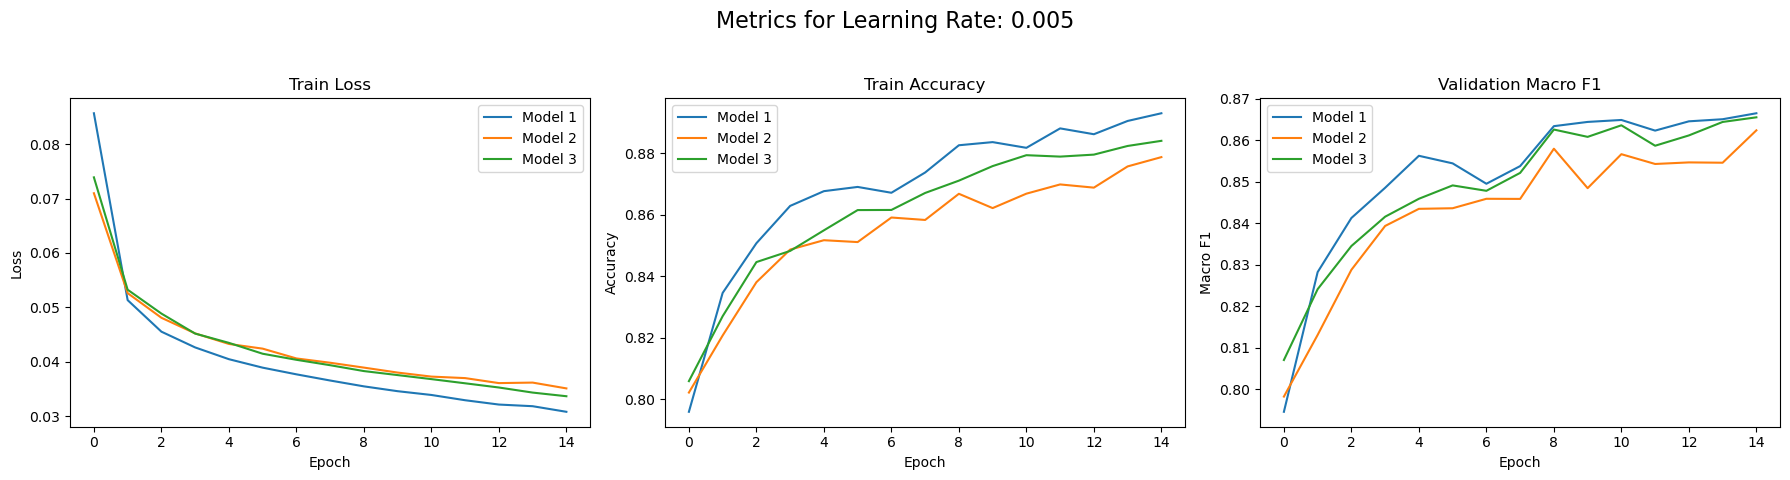

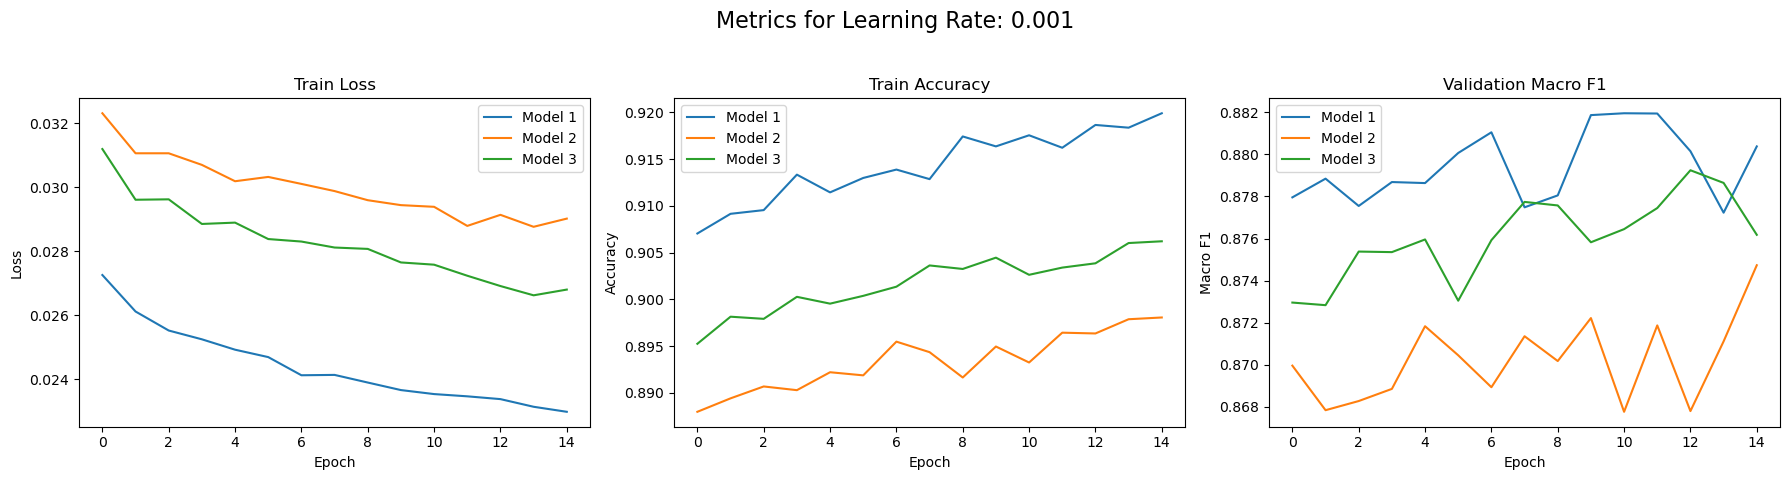

Epoch 9/15: 100%|██████████| 240/240 [28:08<00:00,  7.03s/batch]


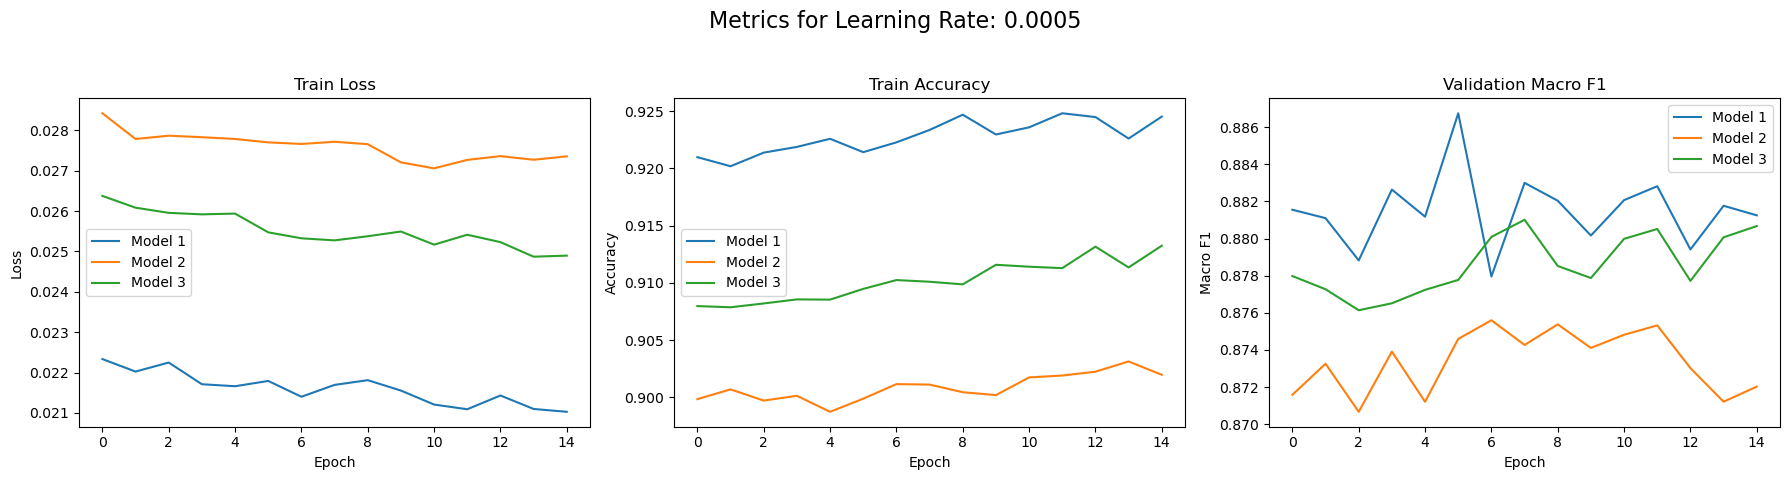

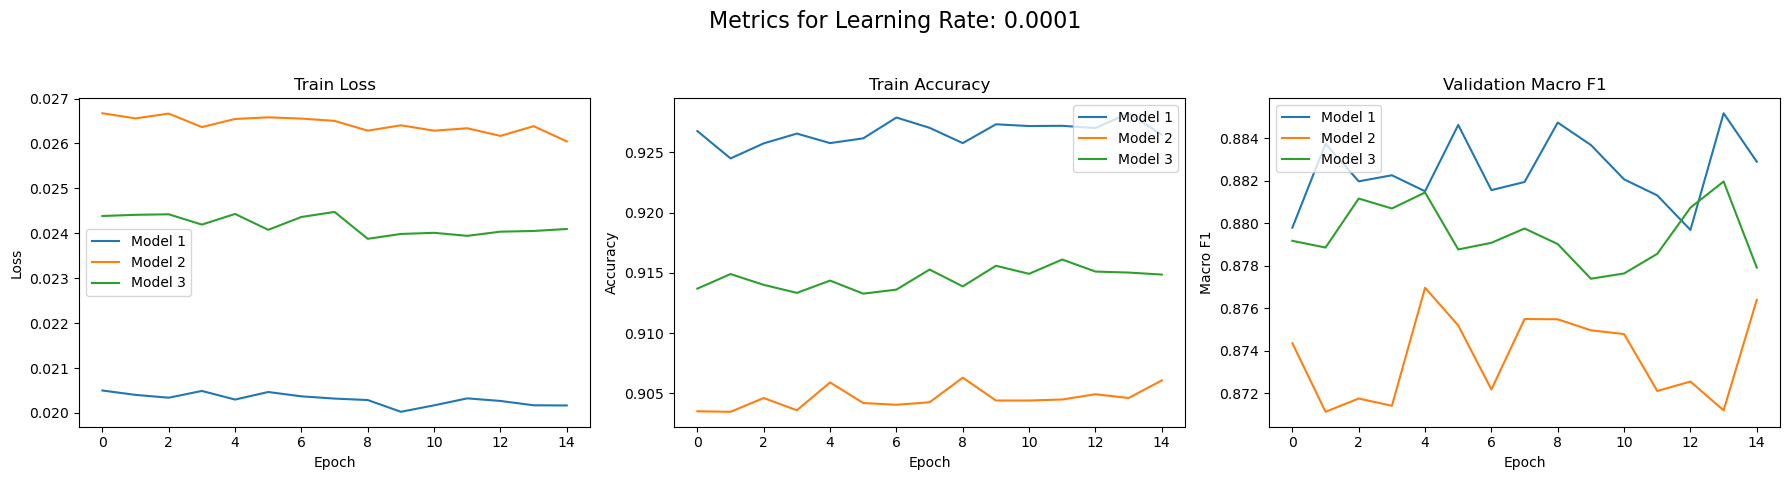

In [31]:
def plot_metrics(history):
    for lr, models_metrics in history.items():
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
        fig.suptitle(f"Metrics for Learning Rate: {lr}", fontsize=16)
        
        metrics_titles = ["Train Loss", "Train Accuracy", "Validation Macro F1"]
        y_labels = ["Loss", "Accuracy", "Macro F1"]
        
        for model_index, metrics_history in enumerate(models_metrics):
            metrics_df = pd.DataFrame(
                metrics_history,
                columns=["Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy", "Val Macro F1"]
            )
            
            for i, (ax, title, y_label) in enumerate(zip(axes, metrics_titles, y_labels)):
                if title == "Train Loss":
                    y_data = metrics_df["Train Loss"]
                elif title == "Train Accuracy":
                    y_data = metrics_df["Train Accuracy"]
                elif title == "Validation Macro F1":
                    y_data = metrics_df["Val Macro F1"]
                
                ax.plot(y_data, label=f"Model {model_index + 1}")
                ax.set_title(title)
                ax.set_xlabel("Epoch")
                ax.set_ylabel(y_label)
                ax.legend()
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
        plt.show()

plot_metrics(history)

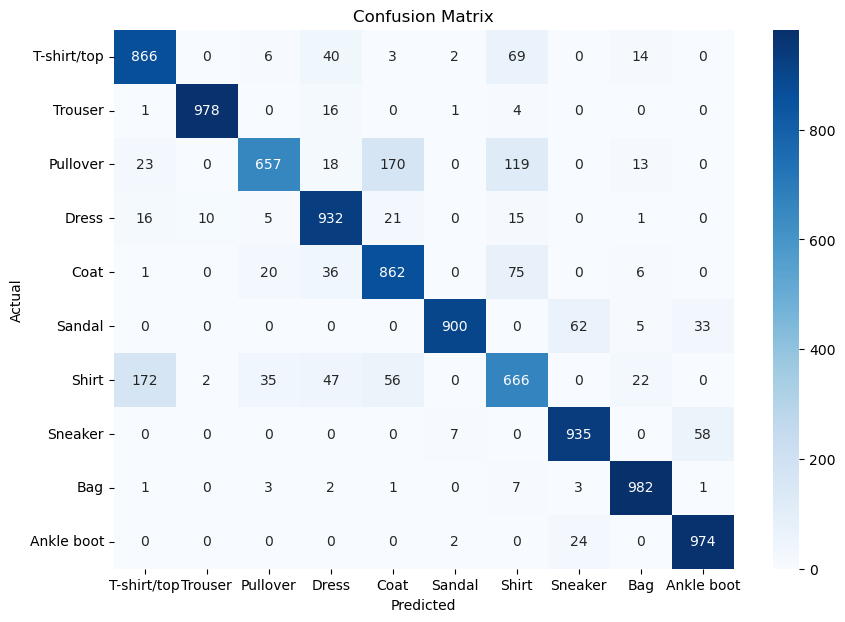

Test Accuracy: 0.8752
Test Macro F1 Score: 0.8735


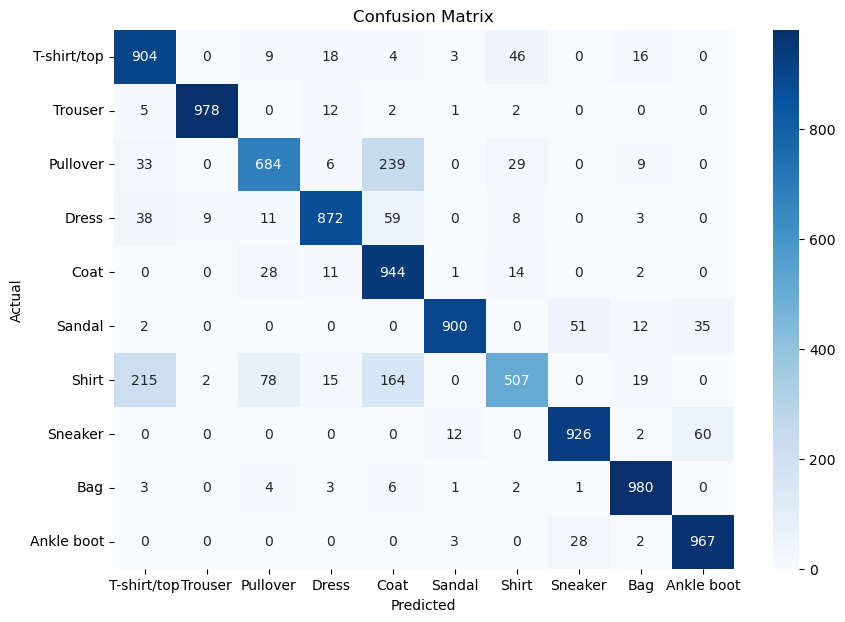

Test Accuracy: 0.8662
Test Macro F1 Score: 0.8628


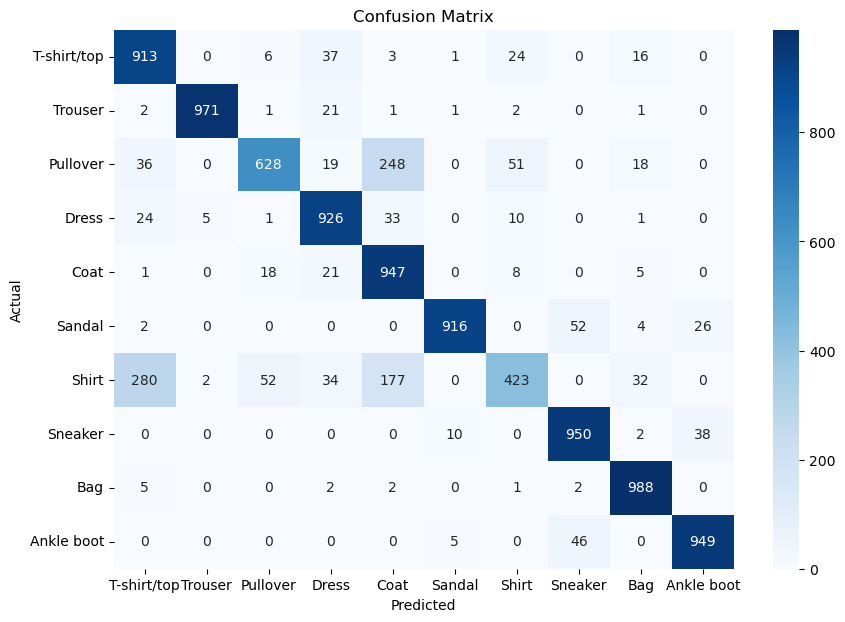

Test Accuracy: 0.8611
Test Macro F1 Score: 0.8540


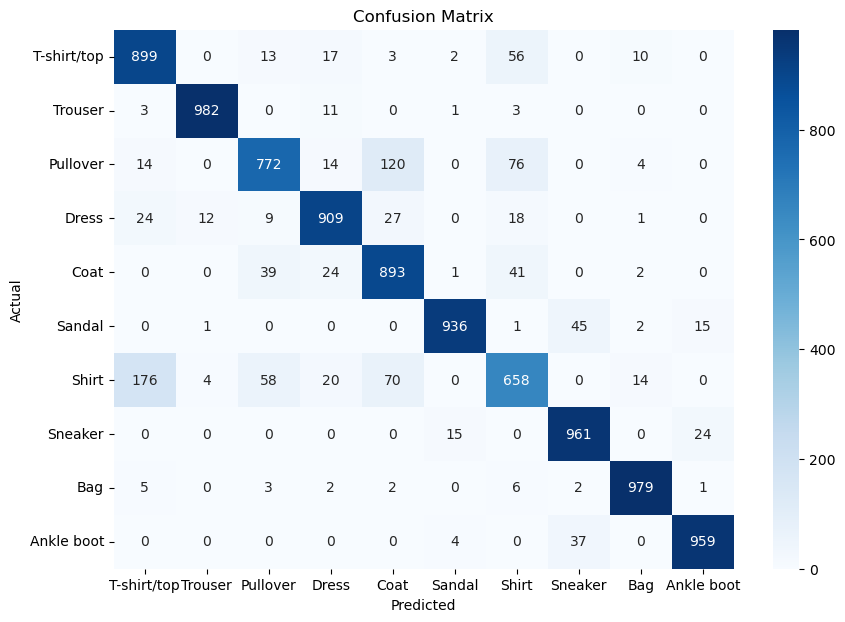

Test Accuracy: 0.8948
Test Macro F1 Score: 0.8936


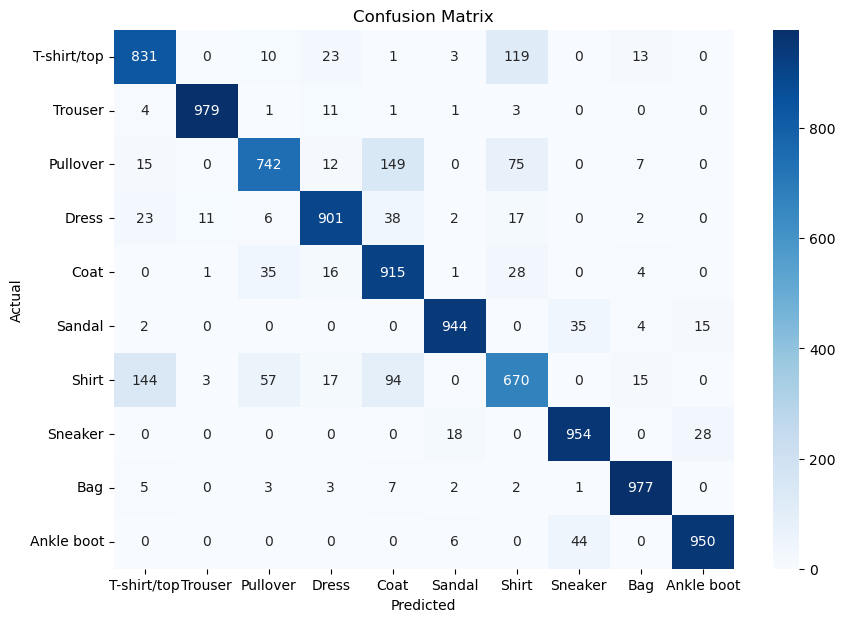

Test Accuracy: 0.8863
Test Macro F1 Score: 0.8855


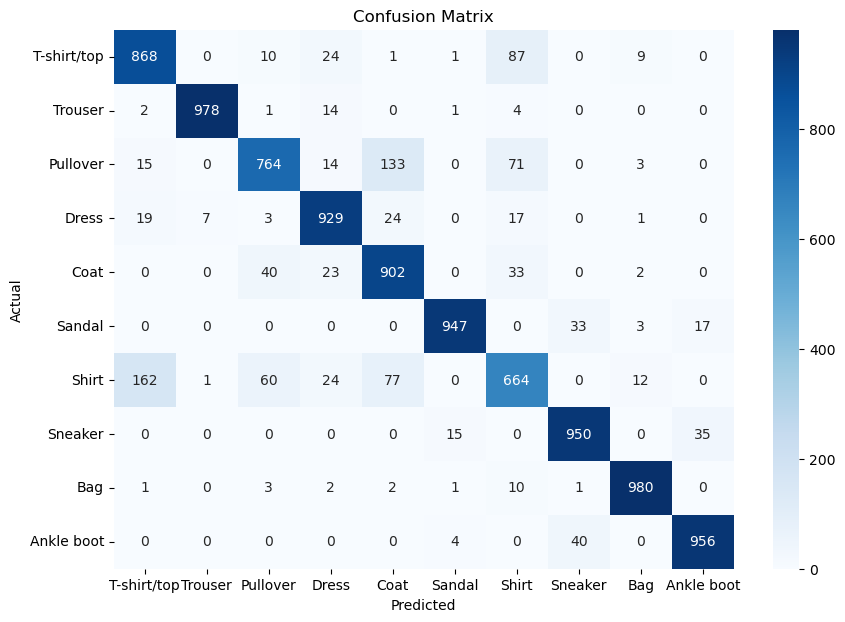

Test Accuracy: 0.8938
Test Macro F1 Score: 0.8928


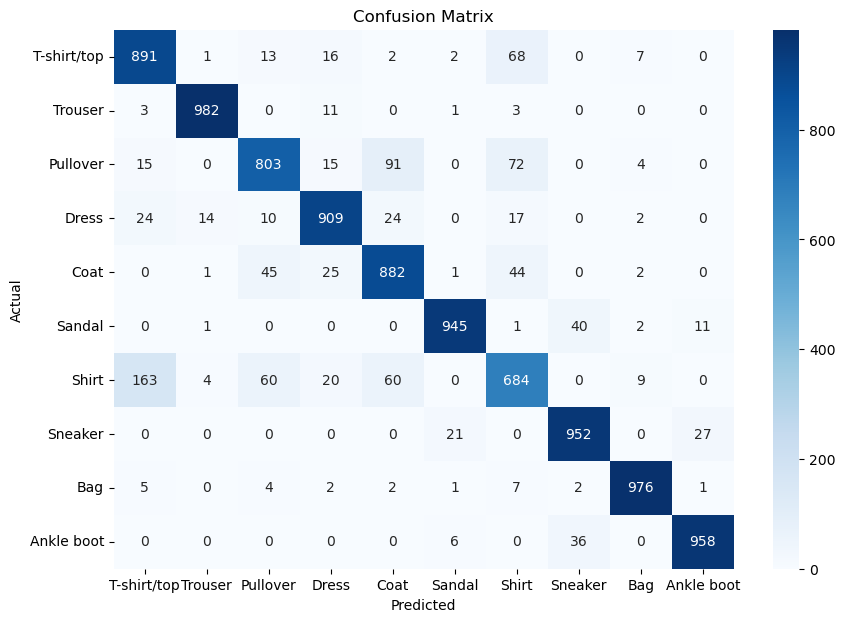

Test Accuracy: 0.8982
Test Macro F1 Score: 0.8974


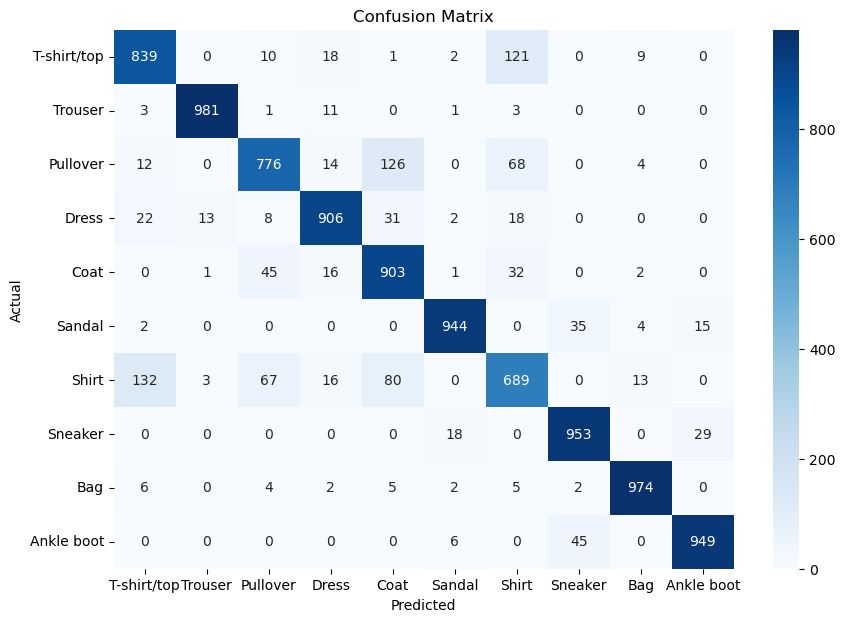

Test Accuracy: 0.8914
Test Macro F1 Score: 0.8909


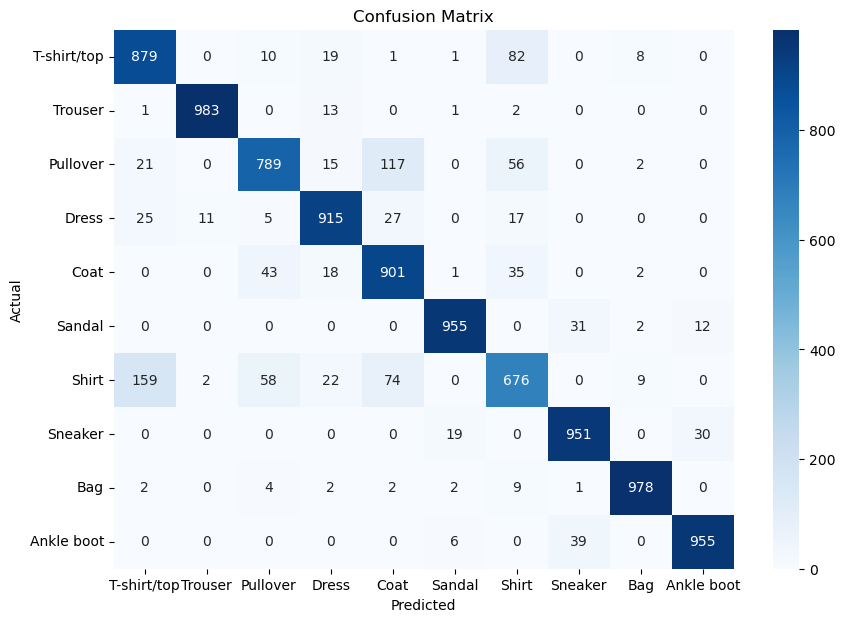

Test Accuracy: 0.8982
Test Macro F1 Score: 0.8973


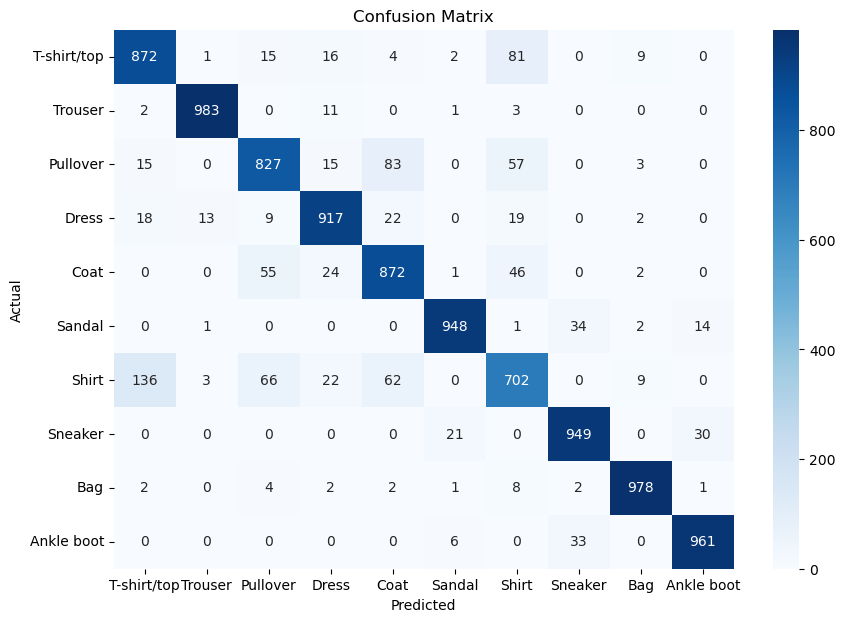

Test Accuracy: 0.9009
Test Macro F1 Score: 0.9003


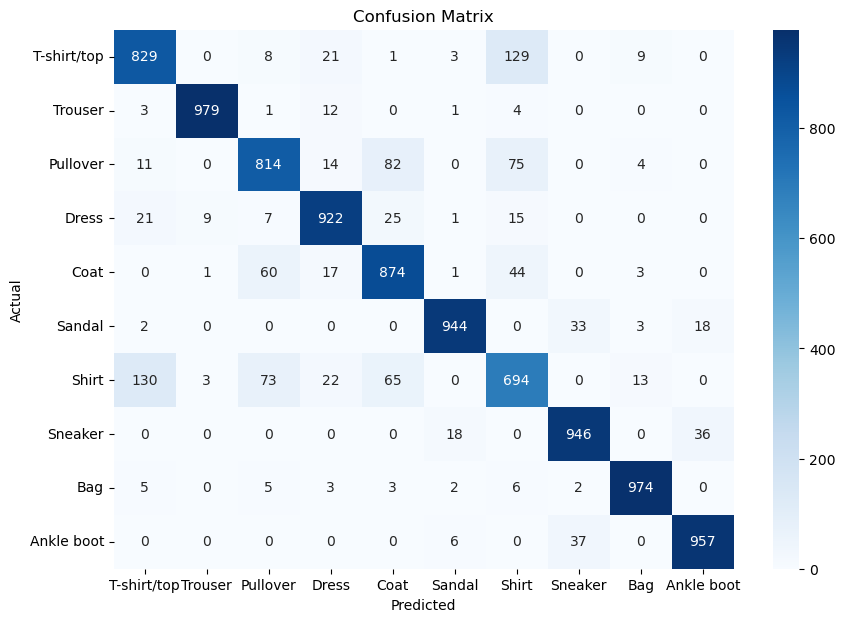

Test Accuracy: 0.8933
Test Macro F1 Score: 0.8930


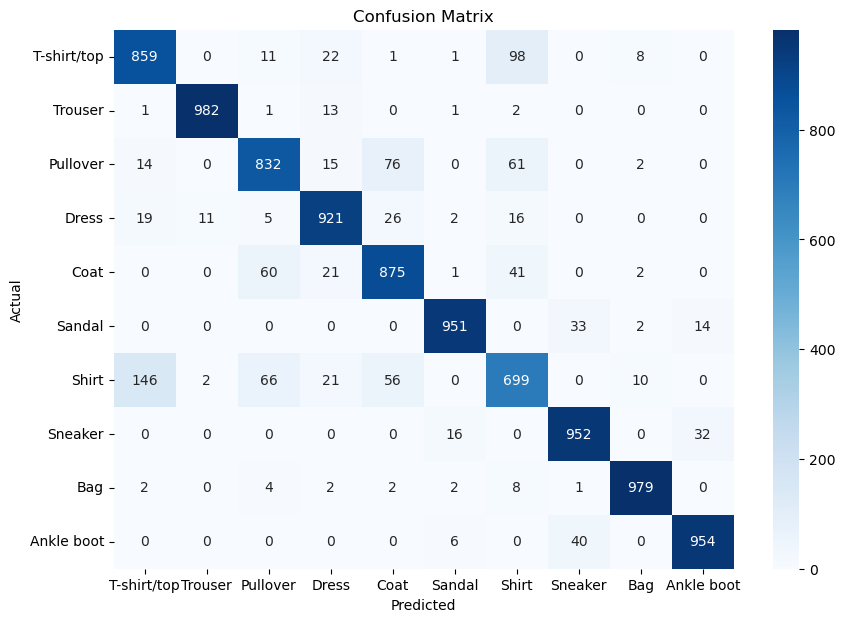

Test Accuracy: 0.9004
Test Macro F1 Score: 0.8999
-------------------------- Best Model ----------------------------


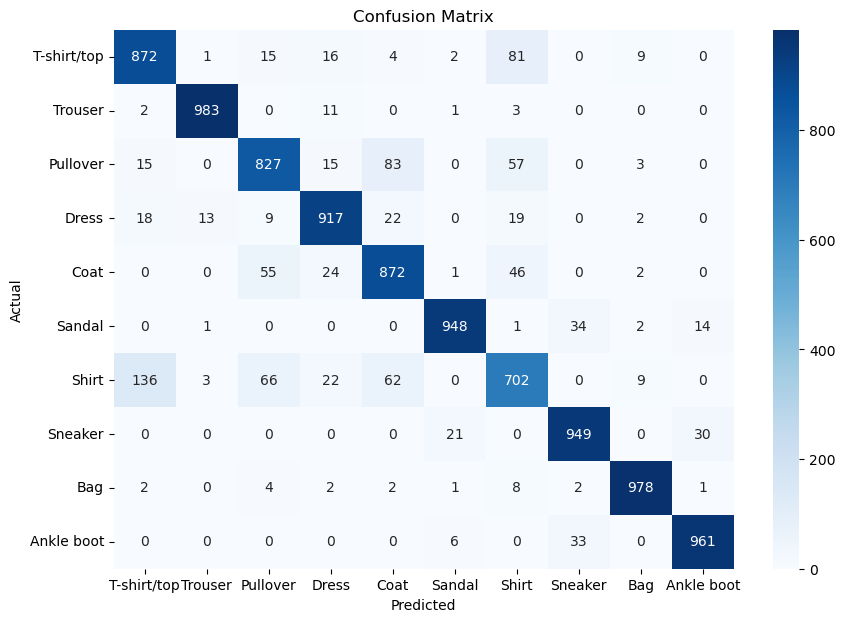

Test Accuracy: 0.9009
Test Macro F1 Score: 0.9003


In [32]:
for lr in learning_rates:
    for model_index in range(3):
        load_model_weights(models[model_index], f'model_{model_index + 1}_lr_{lr}.pkl')
        test_accuracy, test_macro_f1 = test_and_evaluate(models[model_index], test_X, test_y)

print("-------------------------- Best Model ----------------------------")

load_model_weights(best_model, 'best_model.pkl')
test_accuracy, test_macro_f1 = test_and_evaluate(best_model, test_X, test_y)
